In [336]:
import numpy as np
import random
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [332]:
import warnings
warnings.filterwarnings("ignore")

### Challenge 1

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
import mglearn
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import Normalizer
import sys
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

/Users/admin/anaconda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/admin/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [613]:
demo.shape

(10844, 6)

In [4]:
hm=pd.read_csv("/Users/admin/desktop/data incubator 2020/happydb/cleaned_hm.csv")
demo=pd.read_csv("/Users/admin/desktop/data incubator 2020/happydb/demographic.csv")

In [46]:
demo.index=demo.wid

In [47]:
hm.shape,demo.shape

((100535, 14), (10844, 6))

In [48]:
hm.ground_truth_category.value_counts()

affection           4810
achievement         4276
bonding             1750
enjoy_the_moment    1514
leisure             1306
nature               252
exercise             217
Name: ground_truth_category, dtype: int64

In [8]:
hm.predicted_category.value_counts()

affection           34168
achievement         33993
enjoy_the_moment    11144
bonding             10727
leisure              7458
nature               1843
exercise             1202
Name: predicted_category, dtype: int64

In [9]:
hm['age']=hm.wid.replace(demo.age)
hm['country']=hm.wid.replace(demo.country)
hm['gender']=hm.wid.replace(demo.gender)
hm['marital']=hm.wid.replace(demo.marital)
hm['parenthood']=hm.wid.replace(demo.parenthood)

In [10]:
hm.gender.value_counts()

m    57690
f    42069
o      697
Name: gender, dtype: int64

In [60]:
#use marital to clean the age catogories - if anyone is aged less than 14 (for example) 
#and is belongs to any of the unreasonal marital status will be discarded
hm.groupby('marital').count().wid/hm.shape[0]

marital
divorced     0.037828
married      0.411230
separated    0.006455
single       0.538181
widowed      0.004745
Name: wid, dtype: float64

In [62]:
#use parenthood to clean the age catogories - if anyone is aged less than 10 (for example) 
#and is belongs to any of the unreasonal marital status will be discarded
hm.groupby('parenthood').count().wid/hm.shape[0]

parenthood
n    0.606127
y    0.393097
Name: wid, dtype: float64

In [59]:
#whether country can be separated into two groups - developing and developed
hm['country'].value_counts().shape

(100,)

In [63]:
#age need to be cleaned, I trust respond from age 4~5 to 100
hm['age'].value_counts().sort_index().head()

17.0      6
18      245
18.0    219
19      564
19.0    440
Name: age, dtype: int64

### Data cleaning

In [66]:
hm.dtypes

hmid                      int64
wid                       int64
reflection_period        object
original_hm              object
cleaned_hm               object
modified                   bool
num_sentence              int64
ground_truth_category    object
predicted_category       object
age                      object
country                  object
gender                   object
marital                  object
parenthood               object
dtype: object

In [74]:
hm.shape

(100535, 14)

In [91]:
age_txt=[]
for i in range(len(hm)):
    try:
        float(hm.age.iloc[i])
    except ValueError:
        age_txt.append(hm.age.iloc[i])

In [93]:
np.unique(age_txt)

array(['60yrs', 'prefer not to say', 'čá'], dtype='<U17')

In [187]:
hm_age_c.shape

(100490, 14)

In [294]:
hm_age_c=hm[hm.age!='prefer not to say']
hm_age_c=hm_age_c[hm_age_c.age!='čá']
hm_age_c=hm_age_c.replace('60yrs',60.0)

In [295]:
hm_age_c.age=pd.to_numeric(hm_age_c.age)

In [296]:
## or age with parenthood stus to clean anormalies
age14_p_idx=hm_age_c.index[np.where((hm_age_c.age<14)& (hm_age_c.parenthood=='y'))[0]] # 3 persons

In [297]:
# use info from age and marital status
age14_d_idx=hm_age_c.index[np.where((hm_age_c.age<14)& (hm_age_c.marital=='divorced'))[0]] #0 person
age14_m_idx=hm_age_c.index[np.where((hm_age_c.age<14)& (hm_age_c.marital=='married'))[0]] #2 persons (6 counts) one USA, one german
age14_w_idx=hm_age_c.index[np.where((hm_age_c.age<14)& (hm_age_c.marital=='widowed'))[0]] # 0 persons
age14_s_idx=hm_age_c.index[np.where((hm_age_c.age<14)& (hm_age_c.marital=='separated'))[0]] # 0 persons

In [298]:
for txt in ['p','d','m','w','s']:
    try:
        hm_age_c=hm_age_c.drop(globals()['age14_'+txt+'_idx'])
    except KeyError:
        continue

In [299]:
age5_idx=hm_age_c.index[np.where(hm_age_c.age<5)]

In [300]:
hm_age_c.loc[age5_idx].wid.value_counts()
#after examing the sentence they wrote, it 's clear that they are adults or at least more than the age they claim they are
#for simplication and lack of information for correction I simply discard the four persons info

62       75
3554      6
12450     3
12446     3
Name: wid, dtype: int64

In [301]:
hm_age_c=hm_age_c.drop(age5_idx)

In [302]:
age15_idx=hm_age_c.index[np.where(hm_age_c.age<15)]

In [303]:
hm_age_c.age.value_counts().sort_index().head()

17.0       6
18.0     464
19.0    1004
20.0    1517
21.0    2536
Name: age, dtype: int64

In [304]:
hm_age_c.age.value_counts().sort_index().tail()

88.0      6
95.0      3
98.0      3
227.0     9
233.0    51
Name: age, dtype: int64

In [305]:
#all from the same person and she has a grandmother, obviously a typo for her age, no info for correction, thus discard directly
hm_age_c=hm_age_c.drop(hm_age_c.index[np.where(hm_age_c.age==227)[0]])

In [306]:
hm_age_c[hm_age_c.age==233].original_hm.iloc[2]
#obviously another typo for age,and all from the same person

'My mom and sister and I were laughing about memories together. Was a change from how things normally are in my house. Was nice.'

In [307]:
hm_age_c=hm_age_c.drop(hm_age_c.index[np.where(hm_age_c.age==233)[0]])

In [227]:
# hm_age_c[(hm_age_c.age>80)&(hm_age_c.marital=='single')].wid.value_counts()

In [230]:
#after cleaning the dataset based on age
# hm_age_c.groupby('wid').count()

In [308]:
#drop Nan in age
hm_age_c=hm_age_c.dropna(subset=['age'])

In [394]:
hm_age_c=hm_age_c.drop(hm_age_c.index[hm_age_c.gender=='o'])

In [396]:
# hm_age_c

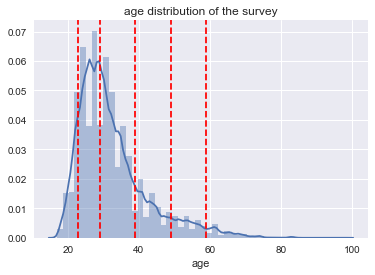

In [612]:
sns.distplot(hm_age_c.age)
plt.title('age distribution of the survey')
plt.axvline(x=23,c='red',ls='--')
plt.axvline(x=29,c='red',ls='--')
plt.axvline(x=39,c='red',ls='--')
plt.axvline(x=49,c='red',ls='--')
plt.axvline(x=59,c='red',ls='--')

In [310]:
hm_age_c['age17-23']=hm_age_c.age.apply(lambda x: (x<=24) )
hm_age_c['age24-29']=hm_age_c.age.apply(lambda x: ((x<29) and (x>24)))
hm_age_c['age30-39']=hm_age_c.age.apply(lambda x: ((x<40) and (x>=30)))
hm_age_c['age40-49']=hm_age_c.age.apply(lambda x: ((x<50) and (x>=40)))
hm_age_c['age50-59']=hm_age_c.age.apply(lambda x: ((x<60) and (x>=50)))
hm_age_c['age_60plus']=hm_age_c.age.apply(lambda x: (x>=60))

In [526]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
alltxt=hm_age_c.original_hm.values
vect.fit_transform(alltxt)

<99541x26416 sparse matrix of type '<class 'numpy.int64'>'
	with 1451152 stored elements in Compressed Sparse Row format>

In [527]:
word_freq=vect.vocabulary_

In [528]:
wf_df=pd.DataFrame(word_freq.items(),index=word_freq.keys())

In [530]:
wf_df=wf_df.iloc[:,1]

In [534]:
wf_df_sort=wf_df.sort_values(ascending=False)

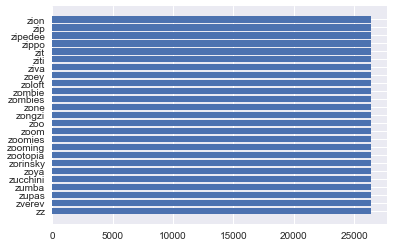

In [607]:
fig, ax = plt.subplots()
ax.barh(np.arange(25), wf_df_sort.iloc[:25], align='center')
ax.set_yticks(np.arange(25))
ax.set_yticklabels(wf_df_sort.index[:25])
plt.show('words with top frequency')
plt.show()

In [550]:
young_data=hm_age_c[hm_age_c['age17-23']==True]
alltxt_young=young_data.original_hm.values
vect.fit_transform(alltxt_young)

<17932x11200 sparse matrix of type '<class 'numpy.int64'>'
	with 251832 stored elements in Compressed Sparse Row format>

In [551]:
word_freq_young=vect.vocabulary_
word_freq_young=pd.DataFrame(word_freq_young.items(),index=word_freq_young.keys())
# word_freq_young_sort={k: v for k, v in sorted(word_freq_young.items(), key=lambda item: item[1],reverse=True)}

In [552]:
word_freq_young=word_freq_young.iloc[:,1]

In [556]:
word_freq_young_sort=word_freq_young.sort_values(ascending=False)

In [559]:
# word_freq_young_sort.tail(100)

### Models trials

#### binomial age prediction

#### age 17-23 collge age (youngest group)

In [560]:
vect = CountVectorizer(min_df=20)

In [609]:
target=hm_age_c['age17-23']
txtpred=hm_age_c.original_hm
X_train,X_test, y_train, y_test=train_test_split(txtpred,target)

In [610]:
X_train_review = vect.fit_transform(X_train)
X_test_review = vect.transform(X_test)
feature_names = vect.get_feature_names()

ROC AUC for title lr with tuning (training set): 0.7476198629399203
ROC AUC for title lr with tuning (testing set): 0.6978338561995238
best C for title lr model: {'C': 0.06309573444801933}


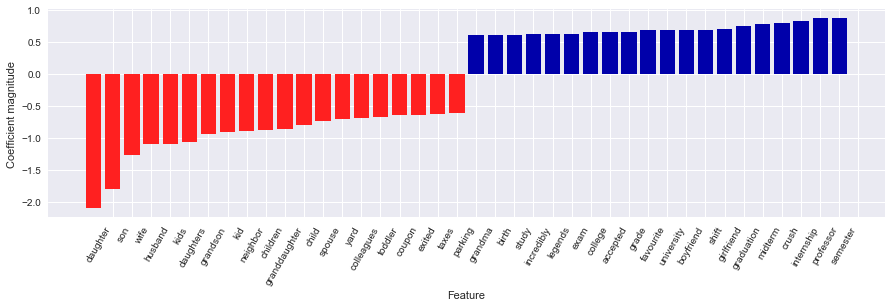

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

In [611]:
#train on vectorizing-title-review-then-concatenate logistic regression with tuning
param_grid = {"C": np.logspace(-2, -1, 6)}
gridlr_title = GridSearchCV(LogisticRegression(class_weight='balanced',solver='lbfgs'), param_grid, cv=8, scoring='roc_auc')
gridlr_title.fit(X_train_review, y_train)
print('ROC AUC for title lr with tuning (training set):',gridlr_title.score(X_train_review,y_train))
print('ROC AUC for title lr with tuning (testing set):',gridlr_title.score(X_test_review,y_test))
print('best C for title lr model:',gridlr_title.best_params_)
mglearn.tools.visualize_coefficients(gridlr_title.best_estimator_.coef_, feature_names, n_top_features=20)
plt.show()
plt.figure(dpi=300)

ROC AUC fo2r title lr with tuning (training set): 0.9995237046560832
ROC AUC for title lr with tuning (testing set): 0.6969866923144045
best C for title lr model: {'tfidfvectorizer__min_df': 1, 'tfidfvectorizer__stop_words': None}


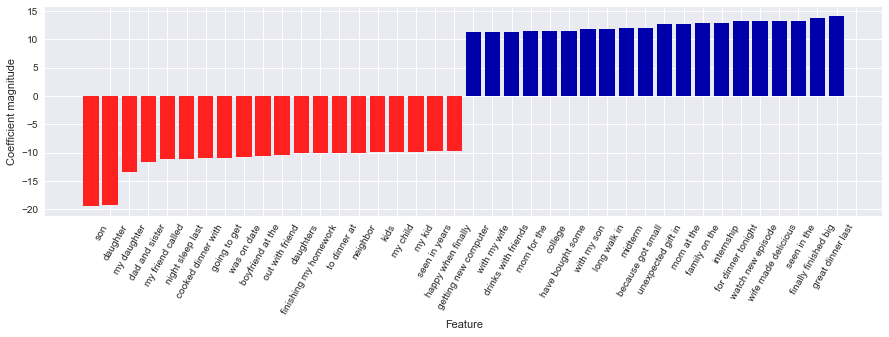

In [344]:
#train on vectorizing-title-review-then-concatenate logistic regression with tuning
param_grid = {"tfidfvectorizer__min_df": [1,2,3],
             "tfidfvectorizer__stop_words":[None, 'english']}
grid_tfid_young = GridSearchCV(make_pipeline(TfidfVectorizer(ngram_range=(1,3)), 
                            LogisticRegressionCV(class_weight='balanced',solver='sag'), 
                            memory="cache_folder"),param_grid=param_grid,cv=5,scoring="roc_auc")
grid_tfid_young.fit(X_train, y_train)
print('ROC AUC fo2r title lr with tuning (training set):',grid_tfid_young.score(X_train,y_train))
print('ROC AUC for title lr with tuning (testing set):',grid_tfid_young.score(X_test,y_test))
print('best C for title lr model:',grid_tfid_young.best_params_)
feature_names=grid_tfid_young.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names()
mglearn.tools.visualize_coefficients(grid_tfid_young.best_estimator_.named_steps['logisticregressioncv'].coef_, feature_names, n_top_features=20)

#### Young group2 age from 24-29

In [345]:
hm_age_c.columns

Index(['hmid', 'wid', 'reflection_period', 'original_hm', 'cleaned_hm',
       'modified', 'num_sentence', 'ground_truth_category',
       'predicted_category', 'age', 'country', 'gender', 'marital',
       'parenthood', 'age17-23', 'age24-29', 'age30-39', 'age40-49',
       'age50-59', 'age_60plus'],
      dtype='object')

In [349]:
target_y2=hm_age_c['age24-29']
txtpred=hm_age_c.original_hm
X2_train,X2_test, y2_train, y2_test=train_test_split(txtpred,target_y2)

testing score for normalized countvectorizer: 0.6175463549519844
best para: {'logisticregression__C': 1.3894954943731375}


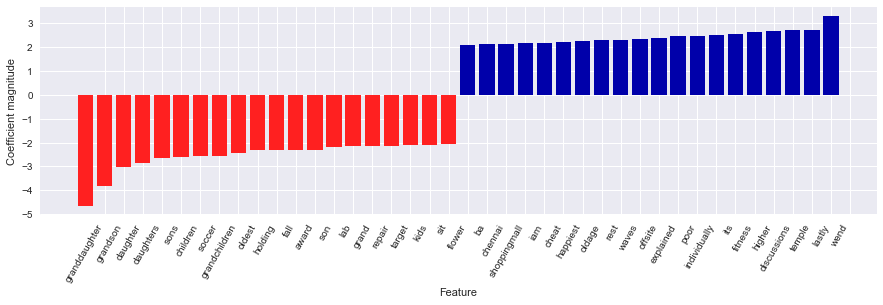

In [352]:
vect_norm_pipe=make_pipeline(CountVectorizer(),Normalizer(),
                             LogisticRegression(class_weight='balanced'), memory="cache_folder")
param_grid = {"logisticregression__C": np.logspace(-0.5,1,8)}
grid = GridSearchCV(vect_norm_pipe,param_grid, cv=8, scoring="roc_auc" )
grid.fit(X2_train, y2_train)
feature_names = grid.best_estimator_.named_steps['countvectorizer'].get_feature_names()
print('testing score for normalized countvectorizer:',grid.score(X2_test,y2_test))
print('best para:',grid.best_params_)
mglearn.tools.visualize_coefficients(grid.best_estimator_.named_steps['logisticregression'].coef_, feature_names, n_top_features=20)

ROC AUC fo2r title lr with tuning (training set): 0.9995116202763875
ROC AUC for title lr with tuning (testing set): 0.6268739000015624
best C for title lr model: {'tfidfvectorizer__stop_words': None}


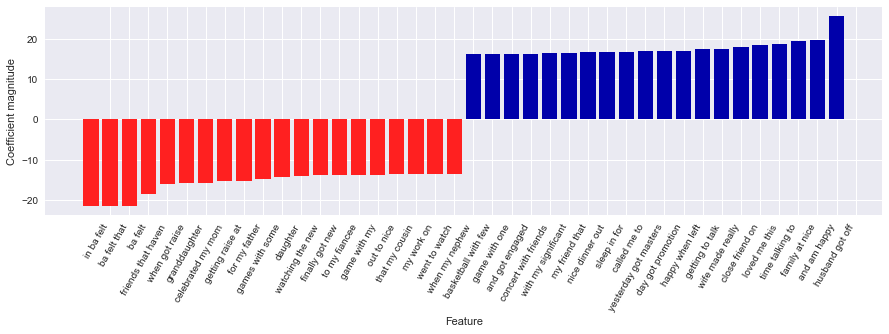

In [385]:
param_grid = {#"tfidfvectorizer__min_df": [0.02,0.025,0.03],
             "tfidfvectorizer__stop_words":[None, 'english']}
grid_tfid_young2 = GridSearchCV(make_pipeline(TfidfVectorizer(ngram_range=(1,3)), 
                            LogisticRegressionCV(class_weight='balanced',solver='sag'), 
                            memory="cache_folder"),param_grid=param_grid,cv=5,scoring="roc_auc")
grid_tfid_young2.fit(X2_train, y2_train)
print('ROC AUC fo2r title lr with tuning (training set):',grid_tfid_young2.score(X2_train,y2_train))
print('ROC AUC for title lr with tuning (testing set):',grid_tfid_young2.score(X2_test,y2_test))
print('best C for title lr model:',grid_tfid_young2.best_params_)
feature_names=grid_tfid_young2.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names()
mglearn.tools.visualize_coefficients(grid_tfid_young2.best_estimator_.named_steps['logisticregressioncv'].coef_, feature_names, n_top_features=20)

#### middle age group 30 - 39

In [378]:
target_md1=hm_age_c['age30-39']
txtpred=hm_age_c.original_hm
X3_train,X3_test, y3_train, y3_test=train_test_split(txtpred,target_md1)

training score for normalized countvectorizer: 0.6825853275982081
testing score for normalized countvectorizer: 0.6015168095933991
best para: {'logisticregression__C': 0.7196856730011519}


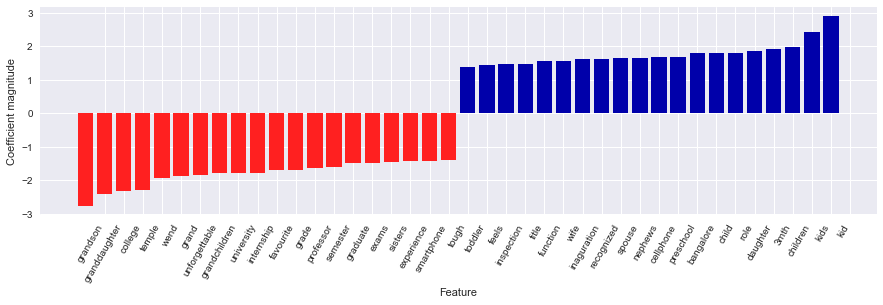

In [379]:
vect_norm_pipe=make_pipeline(CountVectorizer(),Normalizer(),
                             LogisticRegression(class_weight='balanced'), memory="cache_folder")
param_grid = {"logisticregression__C": np.logspace(-1,1,8)}
grid = GridSearchCV(vect_norm_pipe,param_grid, cv=8, scoring="roc_auc" )
grid.fit(X3_train, y3_train)
feature_names = grid.best_estimator_.named_steps['countvectorizer'].get_feature_names()
print('training score for normalized countvectorizer:',grid.score(X3_train,y3_train))
print('testing score for normalized countvectorizer:',grid.score(X3_test,y3_test))
print('best para:',grid.best_params_)
mglearn.tools.visualize_coefficients(grid.best_estimator_.named_steps['logisticregression'].coef_, feature_names, n_top_features=20)

#### middle age group2 40 - 49

In [380]:
target_md2=hm_age_c['age40-49']
txtpred=hm_age_c.original_hm
X4_train,X4_test, y4_train, y4_test=train_test_split(txtpred,target_md2)

training score for normalized countvectorizer: 0.7659076563365741
testing score for normalized countvectorizer: 0.6541329057188433
best para: {'logisticregression__C': 0.7196856730011519}


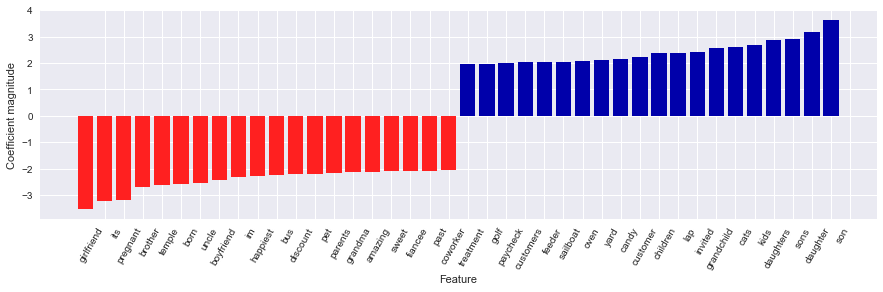

In [381]:
vect_norm_pipe=make_pipeline(CountVectorizer(),Normalizer(),
                             LogisticRegression(class_weight='balanced'), memory="cache_folder")
param_grid = {"logisticregression__C": np.logspace(-1,0.5,8)}
grid = GridSearchCV(vect_norm_pipe,param_grid, cv=8, scoring="roc_auc" )
grid.fit(X4_train, y4_train)
feature_names = grid.best_estimator_.named_steps['countvectorizer'].get_feature_names()
print('training score for normalized countvectorizer:',grid.score(X4_train,y4_train))
print('testing score for normalized countvectorizer:',grid.score(X4_test,y4_test))
print('best para:',grid.best_params_)
mglearn.tools.visualize_coefficients(grid.best_estimator_.named_steps['logisticregression'].coef_, feature_names, n_top_features=20)

ROC AUC fo2r title lr with tuning (training set): 0.9999290666946256
ROC AUC for title lr with tuning (testing set): 0.6405758380314193
best C for title lr model: {'tfidfvectorizer__stop_words': None}


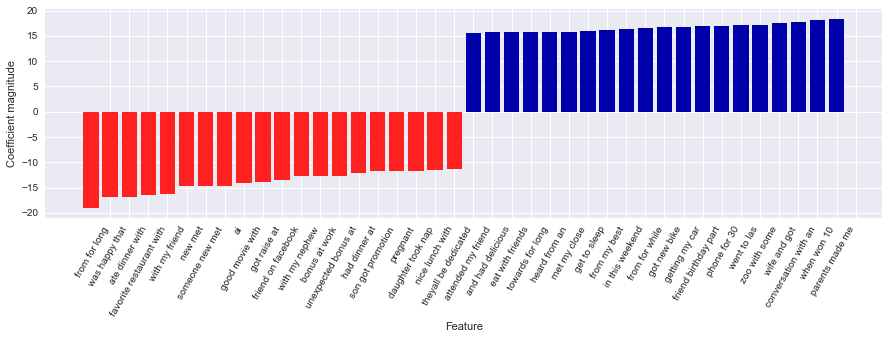

In [386]:
param_grid = {#"tfidfvectorizer__min_df": [0.01,0.05,0.1],
             "tfidfvectorizer__stop_words":[None, 'english']}
grid_tfid_md = GridSearchCV(make_pipeline(TfidfVectorizer(ngram_range=(1,3)), 
                            LogisticRegressionCV(class_weight='balanced',solver='sag'), 
                            memory="cache_folder"),param_grid=param_grid,cv=5,scoring="roc_auc")
grid_tfid_md.fit(X4_train, y4_train)
print('ROC AUC fo2r title lr with tuning (training set):',grid_tfid_md.score(X4_train,y4_train))
print('ROC AUC for title lr with tuning (testing set):',grid_tfid_md.score(X4_test,y4_test))
print('best C for title lr model:',grid_tfid_md.best_params_)
feature_names=grid_tfid_md.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names()
mglearn.tools.visualize_coefficients(grid_tfid_md.best_estimator_.named_steps['logisticregressioncv'].coef_, feature_names, n_top_features=20)

#### middle age group3 50 - 59

In [382]:
target_md3=hm_age_c['age50-59']
txtpred=hm_age_c.original_hm
X5_train,X5_test, y5_train, y5_test=train_test_split(txtpred,target_md3)

training score for normalized countvectorizer: 0.8527008621394687
testing score for normalized countvectorizer: 0.6831120025240247
best para: {'logisticregression__C': 0.7498942093324559}


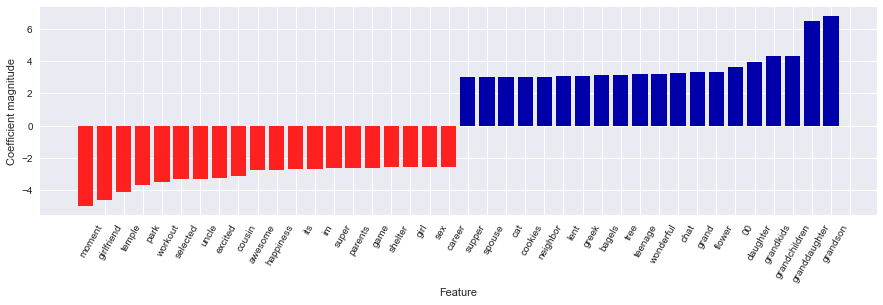

In [383]:
vect_norm_pipe=make_pipeline(CountVectorizer(),Normalizer(),
                             LogisticRegression(class_weight='balanced'), memory="cache_folder")
param_grid = {"logisticregression__C": np.logspace(-0.5,1,5)}
grid = GridSearchCV(vect_norm_pipe,param_grid, cv=8, scoring="roc_auc" )
grid.fit(X5_train, y5_train)
feature_names = grid.best_estimator_.named_steps['countvectorizer'].get_feature_names()
print('training score for normalized countvectorizer:',grid.score(X5_train,y5_train))
print('testing score for normalized countvectorizer:',grid.score(X5_test,y5_test))
print('best para:',grid.best_params_)
mglearn.tools.visualize_coefficients(grid.best_estimator_.named_steps['logisticregression'].coef_, feature_names, n_top_features=20)

In [ ]:
# param_grid = {"tfidfvectorizer__min_df": [3,4,5]}
# grid_tfid_md = GridSearchCV(make_pipeline(TfidfVectorizer(ngram_range=(1,3)), 
#                             LogisticRegressionCV(class_weight='balanced',solver='sag'), 
#                             memory="cache_folder"),param_grid=param_grid,cv=5,scoring="roc_auc")
# grid_tfid_md.fit(X3_train, y3_train)
# print('ROC AUC fo2r title lr with tuning (training set):',grid_tfid_md.score(X3_train,y3_train))
# print('ROC AUC for title lr with tuning (testing set):',grid_tfid_md.score(X3_test,y3_test))
# print('best C for title lr model:',grid_tfid_md.best_params_)
# feature_names=grid_tfid_md.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names()
# mglearn.tools.visualize_coefficients(grid_tfid_md.best_estimator_.named_steps['logisticregressioncv'].coef_, feature_names, n_top_features=20)

#### the elder group 60 +

In [360]:
target_o=hm_age_c['age_60plus']
txtpred=hm_age_c.original_hm
X5_train,X5_test, y5_train, y5_test=train_test_split(txtpred,target_o)

training score for normalized countvectorizer: 0.9268689618637426
testing score for normalized countvectorizer: 0.7505892408209904
best para: {'logisticregression__C': 1.0}


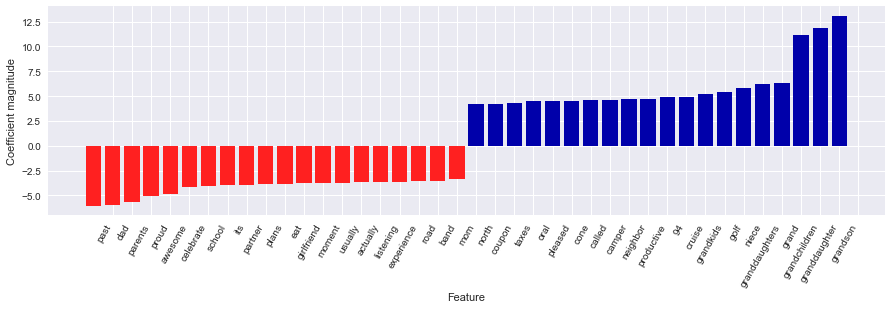

In [361]:
vect_norm_pipe=make_pipeline(CountVectorizer(),Normalizer(),
                             LogisticRegression(class_weight='balanced'), memory="cache_folder")
param_grid = {"logisticregression__C": np.logspace(-2,2,5)}
grid = GridSearchCV(vect_norm_pipe,param_grid, cv=8, scoring="roc_auc" )
grid.fit(X5_train, y5_train)
feature_names = grid.best_estimator_.named_steps['countvectorizer'].get_feature_names()
print('training score for normalized countvectorizer:',grid.score(X5_train,y5_train))
print('testing score for normalized countvectorizer:',grid.score(X5_test,y5_test))
print('best para:',grid.best_params_)
mglearn.tools.visualize_coefficients(grid.best_estimator_.named_steps['logisticregression'].coef_, feature_names, n_top_features=20)

### Gender prediction , female vs male

In [401]:
target_gender=pd.get_dummies(hm_age_c['gender'])[['f']]
txtpred=hm_age_c.original_hm
X6_train,X6_test, y6_train, y6_test=train_test_split(txtpred,target_gender)

training score for normalized countvectorizer: 0.7832709300815508
testing score for normalized countvectorizer: 0.7206674104445694
best para: {'logisticregression__C': 1.7782794100389228}


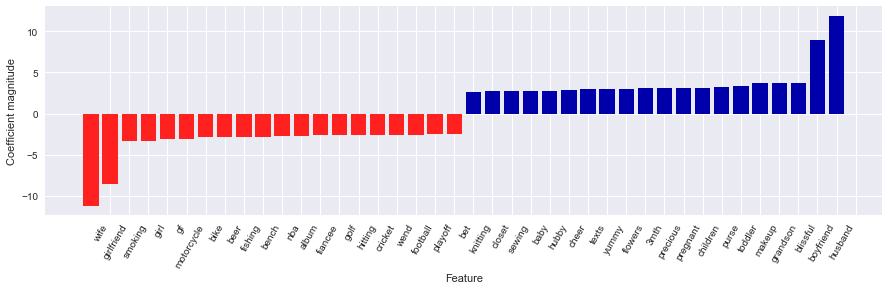

In [402]:
vect_norm_pipe=make_pipeline(CountVectorizer(),Normalizer(),
                             LogisticRegression(class_weight='balanced'), memory="cache_folder")
param_grid = {"logisticregression__C": np.logspace(-0.5,1,5)}
grid = GridSearchCV(vect_norm_pipe,param_grid, cv=8, scoring="roc_auc" )
grid.fit(X6_train, y6_train)
feature_names = grid.best_estimator_.named_steps['countvectorizer'].get_feature_names()
print('training score for normalized countvectorizer:',grid.score(X6_train,y6_train))
print('testing score for normalized countvectorizer:',grid.score(X6_test,y6_test))
print('best para:',grid.best_params_)
mglearn.tools.visualize_coefficients(grid.best_estimator_.named_steps['logisticregression'].coef_, feature_names, n_top_features=20)

### Parenthood prediction - yes vs no

In [566]:
# predicting no
target_parenthood=pd.get_dummies(hm_age_c['parenthood'])[['n']]
txtpred=hm_age_c.original_hm
X8_train,X8_test, y8_train, y8_test=train_test_split(txtpred,target_parenthood)

training score for normalized countvectorizer: 0.7998071302784648
testing score for normalized countvectorizer: 0.7422138570107606
best para: {'logisticregression__C': 1.7782794100389228}


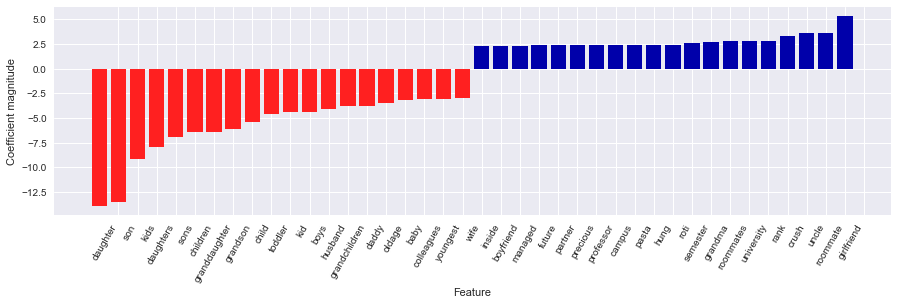

In [411]:
vect_norm_pipe=make_pipeline(CountVectorizer(),Normalizer(),
                             LogisticRegression(class_weight='balanced'), memory="cache_folder")
param_grid = {"logisticregression__C": np.logspace(0,1,6)}
grid_parent = GridSearchCV(vect_norm_pipe,param_grid, cv=8, scoring="roc_auc" )
grid_parent.fit(X8_train, y8_train)
feature_names = grid_parent.best_estimator_.named_steps['countvectorizer'].get_feature_names()
print('training score for normalized countvectorizer:',grid_parent.score(X8_train,y8_train))
print('testing score for normalized countvectorizer:',grid_parent.score(X8_test,y8_test))
print('best para:',grid_parent.best_params_)
mglearn.tools.visualize_coefficients(grid_parent.best_estimator_.named_steps['logisticregression'].coef_, feature_names, n_top_features=20)

### Predicting marital status - only included the two main group married & single

In [436]:
demo.marital.value_counts()/demo.shape[0]

single       0.523608
married      0.403080
divorced     0.052103
separated    0.009406
widowed      0.006547
Name: marital, dtype: float64

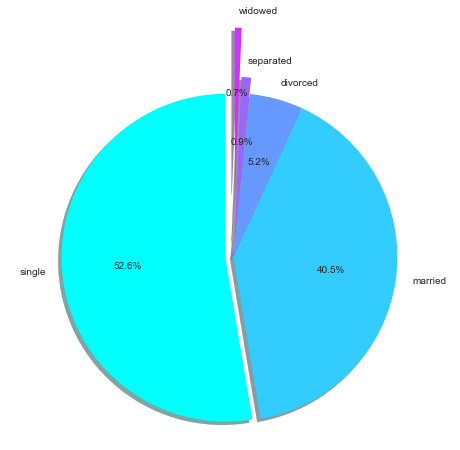

In [574]:
labels = demo.marital.value_counts().index
sizes = demo.marital.value_counts().values
explode = (0.05, 0, 0, 0.1,0.4)  

fig1, ax1 = plt.subplots(figsize=(8,8))
theme = plt.get_cmap('cool')
ax1.set_prop_cycle("color", [theme(1. * i / len(sizes)) for i in range(len(sizes))])
ax1.pie(sizes,   explode=explode,labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_yticklabels({'fontsize=15'})
plt.show()

In [414]:
target_marital_s=pd.get_dummies(hm_age_c['marital'])[['single']]
txtpred=hm_age_c.original_hm
X9_train,X9_test, y9_train, y9_test=train_test_split(txtpred,target_marital_s)

training score for normalized countvectorizer: 0.8045365388268331
testing score for normalized countvectorizer: 0.7312309422610357
best para: {'logisticregression__C': 3.1622776601683795}


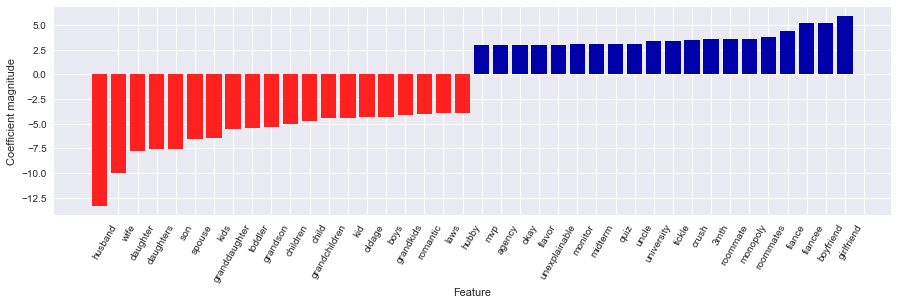

In [416]:
vect_norm_pipe=make_pipeline(CountVectorizer(),Normalizer(),
                             LogisticRegression(class_weight='balanced'), memory="cache_folder")
param_grid = {"logisticregression__C": np.logspace(-1,1,5)}
grid_marital = GridSearchCV(vect_norm_pipe,param_grid, cv=8, scoring="roc_auc" )
grid_marital.fit(X9_train, y9_train)
feature_names = grid_marital.best_estimator_.named_steps['countvectorizer'].get_feature_names()
print('training score for normalized countvectorizer:',grid_marital.score(X9_train,y9_train))
print('testing score for normalized countvectorizer:',grid_marital.score(X9_test,y9_test))
print('best para:',grid_marital.best_params_)
mglearn.tools.visualize_coefficients(grid_marital.best_estimator_.named_steps['logisticregression'].coef_, feature_names, n_top_features=20)

In [417]:
target_marital_m=pd.get_dummies(hm_age_c['marital'])[['married']]
txtpred=hm_age_c.original_hm
X10_train,X10_test, y10_train, y10_test=train_test_split(txtpred,target_marital_m)

training score for normalized countvectorizer: 0.7816552857822818
testing score for normalized countvectorizer: 0.7346918905552816
best para: {'logisticregression__C': 1.0}


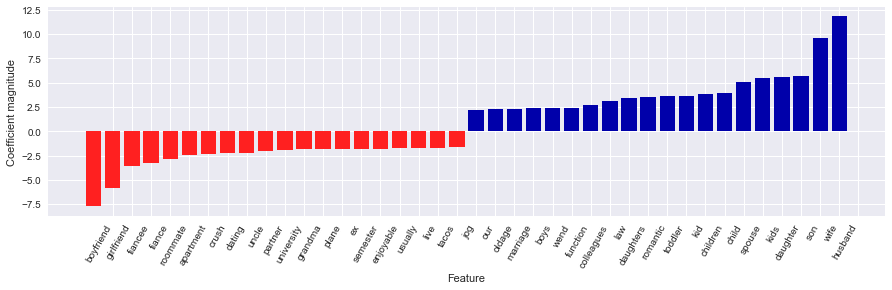

In [418]:
vect_norm_pipe=make_pipeline(CountVectorizer(),Normalizer(),
                             LogisticRegression(class_weight='balanced'), memory="cache_folder")
param_grid = {"logisticregression__C": np.logspace(-1,1,5)}
grid_marital_m = GridSearchCV(vect_norm_pipe,param_grid, cv=8, scoring="roc_auc" )
grid_marital_m.fit(X10_train, y10_train)
feature_names = grid_marital_m.best_estimator_.named_steps['countvectorizer'].get_feature_names()
print('training score for normalized countvectorizer:',grid_marital_m.score(X10_train,y10_train))
print('testing score for normalized countvectorizer:',grid_marital_m.score(X10_test,y10_test))
print('best para:',grid_marital_m.best_params_)
mglearn.tools.visualize_coefficients(grid_marital_m.best_estimator_.named_steps['logisticregression'].coef_, feature_names, n_top_features=20)

#### predicting country - only USA

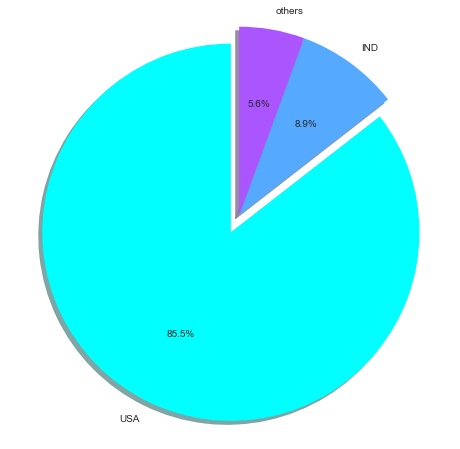

In [575]:
labels = ['USA','IND','others']
sizes = [percent_country.USA,percent_country.IND,(1-percent_country.iloc[:2].sum())]
explode = (0.1, 0, 0)  

fig1, ax1 = plt.subplots(figsize=(8,8))
theme = plt.get_cmap('cool')
ax1.set_prop_cycle("color", [theme(1. * i / len(sizes)) for i in range(len(sizes))])
ax1.pie(sizes,explode=explode,labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90) #
ax1.axis('equal')  
plt.show()

In [576]:
target_USA=pd.get_dummies(hm_age_c['country'])[['USA']]
txtpred=hm_age_c.original_hm
X11_train,X11_test, y11_train, y11_test=train_test_split(txtpred,target_USA)

training score for normalized countvectorizer: 0.9041186140588519
testing score for normalized countvectorizer: 0.8712846066046449
best para: {'logisticregression__C': 5.623413251903491}


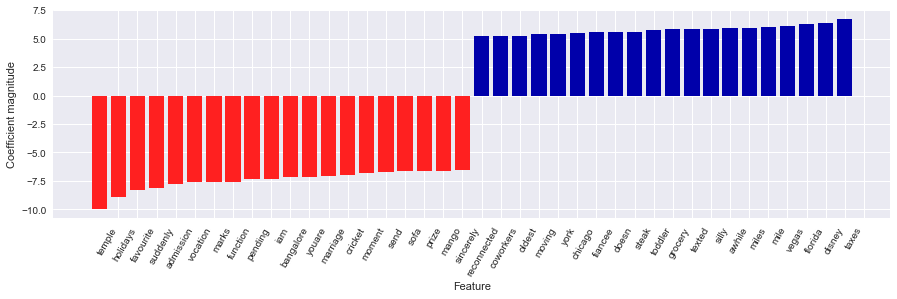

In [577]:
vect_norm_pipe=make_pipeline(CountVectorizer(min_df=20),Normalizer(),
                             LogisticRegression(class_weight='balanced'), memory="cache_folder")
param_grid = {"logisticregression__C": np.logspace(0.5,1.5,5)}
grid_USA = GridSearchCV(vect_norm_pipe,param_grid, cv=8, scoring="roc_auc" )
grid_USA.fit(X11_train, y11_train)
feature_names = grid_USA.best_estimator_.named_steps['countvectorizer'].get_feature_names()
print('training score for normalized countvectorizer:',grid_USA.score(X11_train,y11_train))
print('testing score for normalized countvectorizer:',grid_USA.score(X11_test,y11_test))
print('best para:',grid_USA.best_params_)
mglearn.tools.visualize_coefficients(grid_USA.best_estimator_.named_steps['logisticregression'].coef_, feature_names, n_top_features=20)

In [486]:
grid_USA.best_estimator_.named_steps['logisticregression'].coef_.shape

(1, 23315)

### Topic model

In [508]:
target_y2=pd.get_dummies(hm_age_c['gender'])['m']
txtpred=hm_age_c.original_hm
X2_train,X2_test, y2_train, y2_test=train_test_split(txtpred,target_y2)

In [509]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(min_df=2)
X_train = vect.fit_transform(X2_train)
X_train.shape

(74655, 13473)

In [518]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import NMF
scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X_train)
lsa_scaled = NMF(n_components=100)
X_lsa_scaled = lsa_scaled.fit_transform(X_scaled)

In [520]:
# plt.semilogy(lsa_scaled.explained_variance_ratio_)

In [521]:
lsa_scaled.components_.shape

(100, 13473)

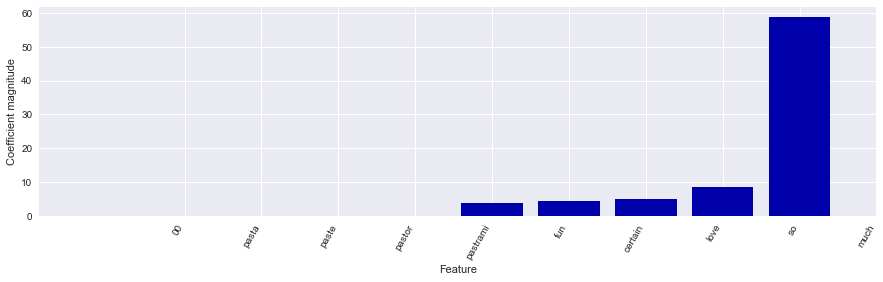

In [522]:
feature_names=vect.get_feature_names()
mglearn.tools.visualize_coefficients(lsa_scaled.components_[0,:], feature_names, n_top_features=5)

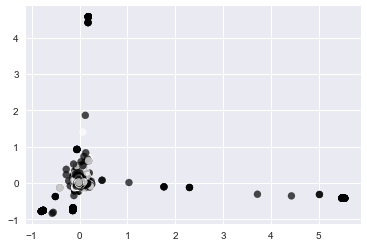

In [516]:
plt.scatter(X_lsa_scaled[:, 2], X_lsa_scaled[:, 3], alpha=.7, c=y2_train)

### Trying to predict the category of the happy moment

In [12]:
target=hm.ground_truth_category
target_predicted=hm.predicted_category
target_predicted_num=preprocessing.label_binarize(target_predicted, classes=[0, 1, 2, 3, 4, 5, 6])

In [14]:
predictors=hm.drop(columns=['ground_truth_category','predicted_category','hmid', 'wid', 'reflection_period','original_hm'])

In [15]:
demopredictor=hm.iloc[:,-5:]
demopredictor_dumm=pd.get_dummies(demopredictor)

In [16]:
X_train,X_test, y_train, y_test=train_test_split(demopredictor_dumm,target_predicted)

In [20]:
X_train_w,X_test_w, y_train_w, y_test_w=train_test_split(predictors.cleaned_hm,target_predicted)

In [21]:
vect = CountVectorizer()
X_train_w = vect.fit_transform(X_train_w)
X_test_w= vect.transform(X_test)
feature_names = vect.get_feature_names()

In [26]:
#train on title logistic regression w/o tuning
from sklearn.svm import LinearSVC
tree_simple =tree.DecisionTreeClassifier(max_depth=2).fit(X_train_w, y_train)
# mglearn.tools.visualize_coefficients(lr.coef_, feature_names, n_top_features=20)
# plt.show()

In [33]:
from sklearn.svm import LinearSVC
# lr =LogisticRegression(class_weight='balanced',multi_class='ovr').fit(X_train_w, y_train_w)
lr_train=lr.score(X_train_w, y_train_w)
lr_test=lr.score(X_train_w, y_train_w)
print("score (training set):",lr_train)
print("score(testing set):",lr_test)
print("C for untuned lr: 1")
# mglearn.tools.visualize_coefficients(lr.coef_, feature_names, n_top_features=20)
# plt.show()

score (training set): 0.9749207570191377
score(testing set): 0.9749207570191377
C for untuned lr: 1
